In [1]:
from eval_one_i3d import run

usage: ipykernel_launcher.py [-h] [-vid_path VID_PATH] [-mode MODE]
                             [-save_model SAVE_MODEL] [-root ROOT]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/jovyan/.local/share/jupyter/runtime/kernel-684fbb1b-c70a-4b15-9714-f54f1fce2f05.json


SystemExit: 2

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [90]:
import math
import os
import argparse


import torch
import torch.nn as nn

import numpy as np

import torch.nn.functional as F
from pytorch_i3d import InceptionI3d

import cv2


# parser = argparse.ArgumentParser()
# parser.add_argument('-vid_path', type=str)
# parser.add_argument('-mode', type=str, help='rgb or flow')
# parser.add_argument('-save_model', type=str)
# parser.add_argument('-root', type=str)

# args = parser.parse_args()


def video_to_tensor(pic):
    """Convert a ``numpy.ndarray`` to tensor.
    Converts a numpy.ndarray (T x H x W x C)
    to a torch.FloatTensor of shape (C x T x H x W)

    Args:
         pic (numpy.ndarray): Video to be converted to tensor.
    Returns:
         Tensor: Converted video.
    """
    return torch.from_numpy(pic.transpose([3, 0, 1, 2]))


def center_crop(img, size = 224):
    t, h, w, c = img.shape
    th, tw = (int(size), int(size))
    i = int(np.round((h - th) / 2.))
    j = int(np.round((w - tw) / 2.))
    return img[:, i:i+th, j:j+tw, :]

def load_rgb_frames_from_video(video_path, start, num):
    vidcap = cv2.VideoCapture(video_path)
    # vidcap = cv2.VideoCapture('/home/dxli/Desktop/dm_256.mp4')

    frames = []

    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
    for offset in range(num):
        success, img = vidcap.read()
        w, h, c = img.shape
        if w < 226 or h < 226:
            d = 226. - min(w, h)
            sc = 1 + d / min(w, h)
            img = cv2.resize(img, dsize=(0, 0), fx=sc, fy=sc)
        img = (img / 255.) * 2 - 1

        frames.append(img)

    return np.asarray(frames, dtype=np.float32)

def prepare_data_mp4(vid_path, mode): #assume .mp4 in title
    num_frames = int(cv2.VideoCapture(vid_path).get(cv2.CAP_PROP_FRAME_COUNT))
    if mode == 'flow':
         num_frames = num_frames // 2

    #label = np.zeros((num_classes, num_frames), np.float32)
    #print((vid_path,0, 0, num_frames, "{}".format(vid_path)))
    vid = load_rgb_frames_from_video(vid_path, 0, num_frames)
    
    return prepare_data(vid, vid_path)

def prepare_data(vid, vid_path):
    imgs = video_to_tensor(center_crop(vid))
    imgs = imgs.unsqueeze(0)   
    return imgs, 0, vid_path.split('.')[0]

   
def make_label_map():
    f_name = "preprocess/msasl_class_list.txt"
    with open(f_name, "r") as f:
        classes = f.readlines()
    strip = lambda x: x.strip()
    class_strip = list(map(strip, classes))
    class_map = {}
    for c in class_strip:
        a = c.split(" ")
        index = int(a[0])
        name = a[1]
        class_map[index] = name
    return class_map

#to update model, just need to change num_classes and weights
#to update preprocessing, go to prepare_data method
def run(video,mode='rgb', weights='weights/nslt_1042_007480_0.516498.pt', num_classes = 1042):
    #class_map = make_label_map()
    if type(video)==str:  
        data = prepare_data_mp4(video, mode)
    else: 
        data = prepare_data(video)

    # setup the model
    if mode == 'flow':
        i3d = InceptionI3d(400, in_channels=2)
        i3d.load_state_dict(torch.load('weights/flow_imagenet.pt'))
    else:
        i3d = InceptionI3d(400, in_channels=3)
        i3d.load_state_dict(torch.load('weights/rgb_imagenet.pt'))
    i3d.replace_logits(num_classes)
    i3d.load_state_dict(torch.load(weights))  
    i3d.cuda()
    i3d = nn.DataParallel(i3d)
    i3d.eval()
    preds = []
    inputs, labels, video_id = data
    
       
    per_frame_logits = i3d(inputs)

    predictions = torch.max(per_frame_logits, dim=2)[0]
    out_labels = np.argsort(predictions.cpu().detach().numpy()[0])
    out_probs = np.sort(predictions.cpu().detach().numpy()[0])
    #print(class_map[out_labels[-1]])
    #return class_map[out_labels[-1]]
    return out_labels[-1]



In [57]:
run('/shared_space/asl_video/wlasl_data_unproc/all night_312_684756.mp4')

'night'

In [26]:
n = 'all night_312_684756.mp4'
name = n.split('_')[0]
name = name.replace('\ufb02','f')
name = name.replace('\ufb01','fi')
name = name.replace('#','')
print(name)

all night


In [58]:
for name in os.listdir('./'):
    if "tell" in name:
        try:
            print(name + ": " + run(name))
        except:
            print(name + " doesn't work")

tell doesn't work
tell_0_069.mp4: old
tell_0_086.mp4: tell
tell_10_56115718.mp4: tomorrow
tell_15_037.mp4: sweet
tell_24_13581531.mp4: deaf
tell_251_3167331702.mp4: water
tell_251_3172831764.mp4: water
tell_265_82248387.mp4: time
tell_3_044.mp4: tell
tell_32_2599426044.mp4: old
tell_32_2607426124.mp4: old
tell_32_97829931.mp4: good
tell_46_87828811.mp4: tell
tell_67_086.mp4: me
tell_72_31083237.mp4: girl
tell_74_1223612274.mp4: water
tell_77_45154575.mp4: red
tell_77_46354685.mp4: tell
tell_77_46854775.mp4: tell
tell_98_57135853.mp4: pink
tell_98_58875921.mp4: tell


In [59]:
for name in os.listdir('./'):
    if "about" in name:
        try:
            print(name + ": " + run(name))
        except:
            print(name + " doesn't work")

about doesn't work
about_11_067.mp4: cherry
about_181_037.mp4: name
about_286_98029901.mp4: around
about_3_049.mp4: about
about_32_50465195.mp4: about
about_34_210255.mp4: soda
about_43_2360323778.mp4: late
about_63_1570815760.mp4: nice


In [60]:
for name in os.listdir('./'):
    if "university" in name:
        try:
            print(name + ": " + run(name))
        except:
            print(name + " doesn't work")

university doesn't work
university_0_061.mp4: college
university_114_058.mp4: some
university_14_0134.mp4: born
university_15_042.mp4: university
university_160_33973525.mp4: university
university_2_0131.mp4: pencil
university_22_41654283.mp4: france
university_26_15491629.mp4: university
university_265_53605490.mp4: learn
university_274_36813879.mp4: university
university_286_16211677.mp4: university
university_3_047.mp4: day
university_32_62026351.mp4: baby
university_40_1174611915.mp4: all
university_40_1284212920.mp4: college
university_40_25202580.mp4: bad
university_431_1369913791.mp4: chicken
university_62_096.mp4: university
university_74_30493147.mp4: learn
university_77_24412571.mp4: noon
university_77_25712632.mp4: help
university_98_39454033.mp4: university


In [ ]:
os.listdir('/shared_space/asl_video/wlasl_data_unproc')

In [34]:
os.chdir('/')

In [39]:
len(os.listdir('/shared_space/asl_video/wlasl_data_unproc'))

21448

In [49]:
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

In [91]:
def generate_confusion_matrix():
    y_true = []
    y_pred = []
    f_name = "preprocess/msasl_class_list.txt"
    with open(f_name, "r") as f:
        classes = f.readlines()
    strip = lambda x: x.strip()
    class_strip = list(map(strip, classes))
    class_map = {}
    for c in class_strip:
        a = c.split(" ")
        index = int(a[0])
        name = " ".join(a[1:])
        class_map[name] = index
    for filename in tqdm_notebook(os.listdir('/shared_space/asl_video/wlasl_data_unproc')):
        name = filename.split('_')[0]
        name = name.replace('\ufb02','f')
        name = name.replace('\ufb01','fi')
        name = name.replace('#','')
        try:
            y_true.append(class_map[name])
        except:
            print("skipping: " + name)
            continue
        y_pred.append(run('/shared_space/asl_video/wlasl_data_unproc/' + filename))
    return y_true, y_pred
        
        

In [93]:
y_true, y_pred = generate_confusion_matrix()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


skipping: able
skipping: educate
skipping: insect
skipping: receive
skipping: receive
skipping: ямВoor
skipping: ямВower
skipping: ямБnish
skipping: ямБre
skipping: ямБshing
skipping: ямБshing
skipping: receive



In [77]:
acc = []
lis = []
for filename in (os.listdir('/shared_space/asl_video/test_data')):
    name = filename.split('_')[0]
    name = name.replace('\ufb02','f')
    name = name.replace('\ufb01','fi')
    name = name.replace('#','')
    if name == 'receive':
        continue
    else:
        lis.append(filename)
    
        

In [86]:
acc = []
for idx, filename in enumerate(lis):
    if y_true[idx] == y_pred[idx]:
        acc.append(filename)

In [87]:
len(acc)

502

In [88]:
len(acc)/2399

0.20925385577323885

In [89]:
with open('unproc_bs4_videos.txt', 'w') as f:
    for row in acc:
        f.write(row + '\n')

In [92]:
unproc_model_y_true = y_true
unproc_model_y_pred = y_pred

In [94]:
import pickle

In [103]:
cm = confusion_matrix(y_true, y_pred, range(1042))

In [109]:
f_name = "preprocess/msasl_class_list.txt"
with open(f_name, "r") as f:
    classes = f.readlines()
strip = lambda x: x.strip()
class_strip = list(map(strip, classes))
class_map = {}
for c in class_strip:
    a = c.split(" ")
    index = int(a[0])
    name = " ".join(a[1:])
    class_map[name] = index

In [108]:
cm.shape

(1042, 1042)

In [106]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

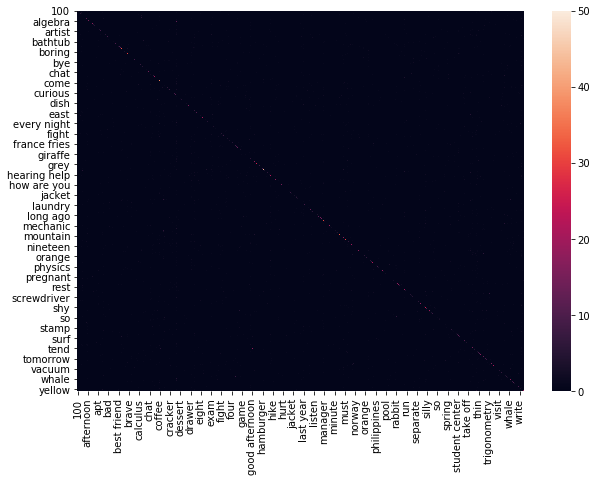

In [115]:
df_cm = pd.DataFrame(cm, index = list(class_map.keys()),
                  columns = list(class_map.keys()))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=False)

In [116]:
cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

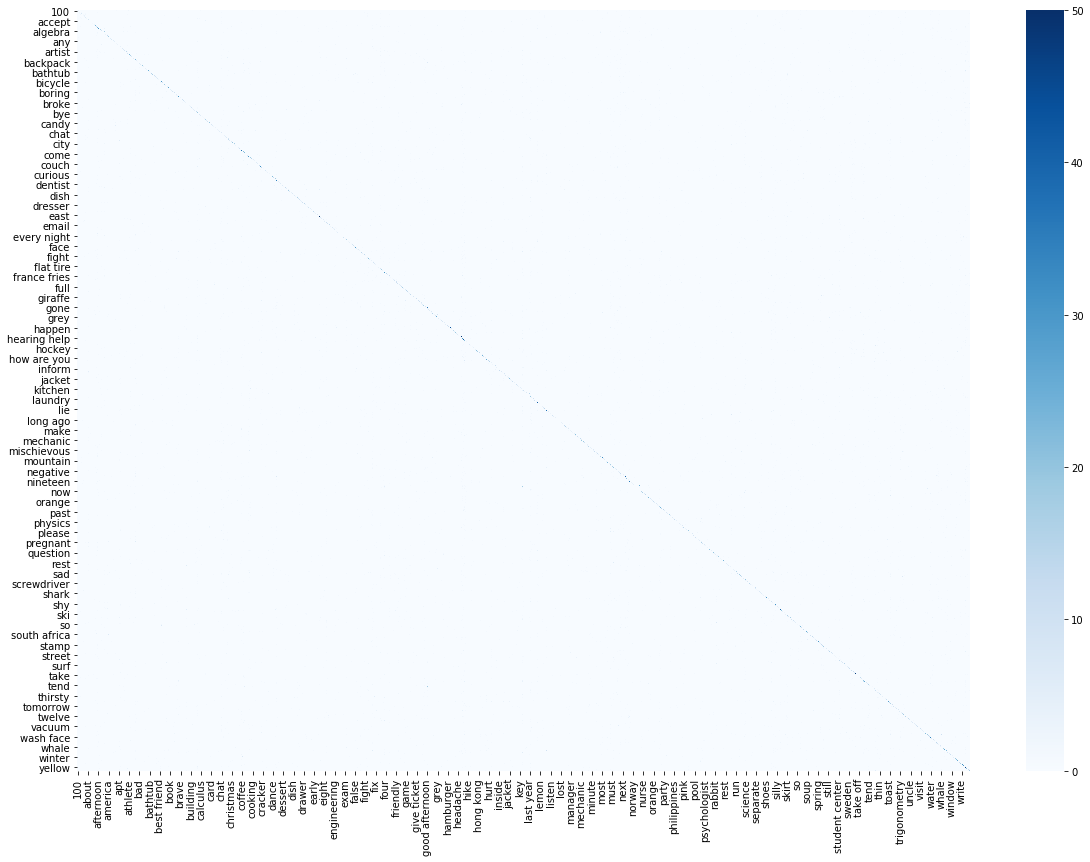

In [136]:
plt.figure(figsize=(20,14))

plot = sns.heatmap(df_cm, cmap='Blues', annot=False)
plot.savefig("cm_train.png")

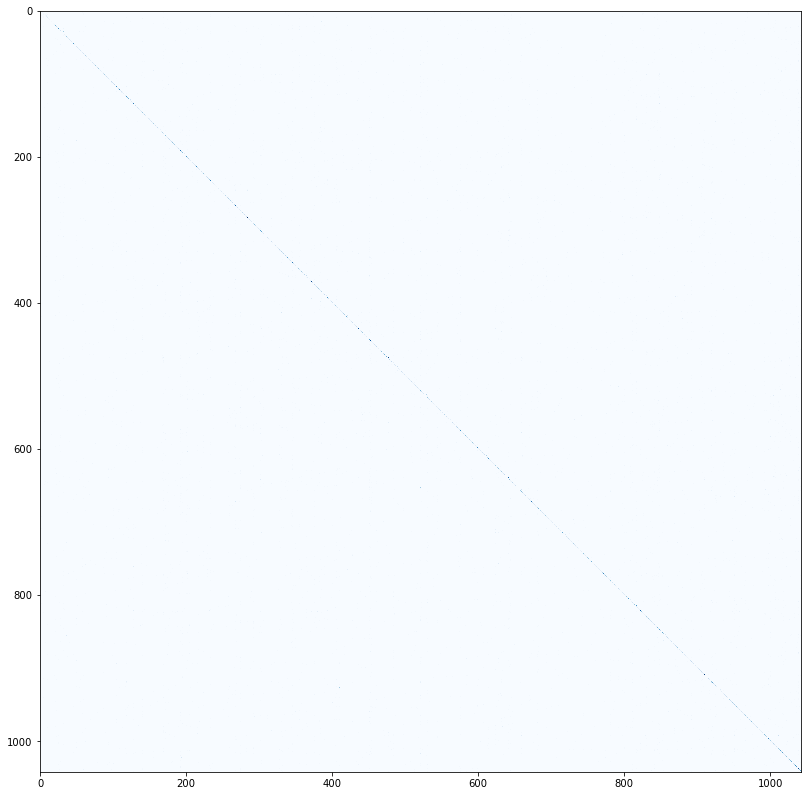

In [131]:
plt.figure(figsize=(20,14))
plt.imshow(cm, cmap='Blues', interpolation='nearest')


In [134]:
np.sum(np.array(y_pred)==np.array(y_true))/len(y_pred)

0.40665236051502146

In [137]:
fig = plot.get_figure()
fig.savefig('cm_train.png') 